# CIFAR 10 mintapélda MLP-vel

## 1.) Inicializáló rész

A feladat megoldását most is a szükséges köynvtárak beimportálásaával, valamint új TensorFlow session létrehozásával kezdjük.

Most már használjuk a GPU-t, de korlátozzuk a TF által egy sessionhöz allokálható memória méretét (ez nem szükséges, ha egy kártyát csak egy folyamat használ, ellenkezőleg viszont elengedhetetlen).

In [1]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.095
session = tf.Session(config=config) # Letrehozunk egy TF session-t a megfelelo mem. korlattal
K.set_session(session) # atadjuk azt a Kerasnak

Using TensorFlow backend.


In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from random import sample as RS
from keras.metrics import top_k_categorical_accuracy

Definiáljuk a mintákat betöltő függvényt, a címkéket megint one-hot coding-ra alakítsuk át:

In [3]:
from keras.datasets import cifar10

def mintak_cifar10():
    (x_tan,y_tan),(x_tst,y_tst)=cifar10.load_data()
    x_tan=x_tan.astype('float32')/255.0
    x_tst=x_tst.astype('float32')/255.0
    classes=['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    idx=RS(set(range(y_tan.size)),5)
    print('Mintakepek es a cimkeik: '+str([x[0] for x in y_tan[idx]]))
    print('Cimkehez tartozo osztalyok: '+str([classes[x[0]] for x in y_tan[idx]]))
    
    (f, sf)=plt.subplots(1, 5)
    f.set_size_inches(16, 6)
    
    for i in range(5):
        img = x_tan[idx[i]]
        sf[i].imshow(img)
    plt.show()
    
    y_tan=to_categorical(y_tan).astype('float32')
    y_tst=to_categorical(y_tst).astype('float32')
    return(x_tan,y_tan,x_tst,y_tst,classes)

Hívjuk meg a függvényt, importáljuk be az adathalmazt

Mintakepek es a cimkeik: [2, 1, 5, 9, 7]
Cimkehez tartozo osztalyok: ['bird', 'auto', 'dog', 'truck', 'horse']


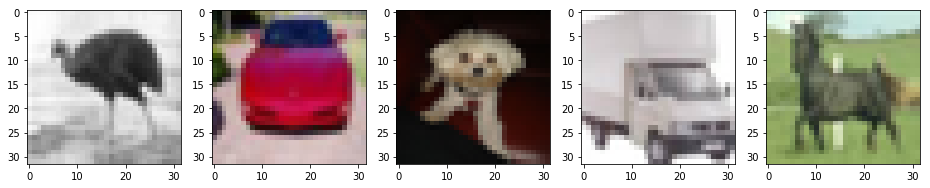

In [4]:
(x_tan,y_tan,x_tst,y_tst,cimke)=mintak_cifar10()

## 2.) Háló létrehozása és betanítása

Ugyanazt az MLP architektúrát és tanító függvényt használjuk most is, mint amit az előző feladatban:

In [5]:
def inTop3(x,y):
    return(top_k_categorical_accuracy(x,y,k=3))

def get_MLP(x_p, y_p):
    bem = Input(shape=x_p[0].shape, dtype='float32')
    x = Flatten()(bem)
    x = Dense(256, activation='tanh')(x)
    x = Dense(128, activation='tanh')(x)
    y = Dense(y_p[0].size, activation='softmax')(x)
    
    model=Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.005, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
    print(model.summary())
    return(model)

def tanitas(model, x_tan, y_tan, epn):
    hst=model.fit(x=x_tan, y=y_tan, verbose=1, batch_size=32, epochs=epn, validation_split=0.1)
    
    plt.title('Tanito gorbek')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    epi=np.linspace(1,epn,epn)
    plt.plot(epi, hst.history['loss'], 'b-', epi, hst.history['val_loss'], 'r-')
    plt.legend(['tanito', 'validacios'], loc='upper left')
    plt.show()
    return model

Hozzuk létre és tanítsuk be az MLP-t:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________
None
Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 34s 747us/step - loss: 1

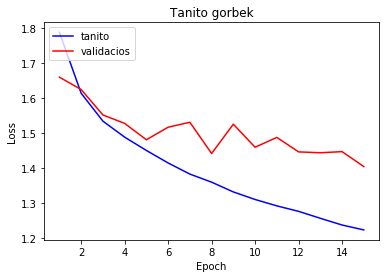

In [6]:
mlp=get_MLP(x_tan,y_tan)
mlp=tanitas(mlp,x_tan,y_tan,15)

A tanítási görbékből látható, hogy kezd túlilleszkedni a háló a tanító adatokra (egyre nagyobb a validációs és a tanító pontok közötti eltérés), noha a validációs hiba még nem növekszik (nincs még túltanulás). Futtassunk még pár epochnyi tanítást.

In [ ]:
mlp=tanitas(mlp,x_tan,y_tan,15)

### Önálló feladat - tanulási függvény kiegészítése korai leállással

Most már emelkedik a validációs hiba, ezért módosítsuk a tanítást végző függvényt, most már a korai leállás is legyen benne. A Keras ezen célra létrehozott callback függvényét alkalmazzuk.

In [ ]:
def tanitas_earlystop(model, x_tan, y_tan, epn, tol):
    
    earlystop=EarlyStopping(monitor='val_loss', patience=tol)
    hst=model.fit(x=x_tan, y=y_tan, verbose=1, batch_size=32, epochs=epn, callbacks=[earlystop], validation_split=0.1)
    
    plt.title('Tanito gorbek')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    epn=len(hst.history['loss'])
    
    epi=np.linspace(1,epn,epn)
    plt.plot(epi, hst.history['loss'], 'b-', epi, hst.history['val_loss'], 'r-')
    plt.legend(['tanito', 'validacios'], loc='upper left')
    plt.show()
    return model

In [ ]:
mlp=tanitas_earlystop(mlp,x_tan,y_tan,10,3)

### Önálló feladat - tanító függvény módosítása: a legjobb validációs eredményhez tartozó súlyokat töltsük vissza

Lehetőség van a tanítás során elért legjobb validációs hibához tartozó súlyok háttértárolóra kimenetésére egy másik Keras callback függvénnyel, most ezzel bővítsük a kódot (ne feledkezzünk meg a súlyok visszatöltéséről sem)!

In [ ]:
def tanitas_earlystop(model, x_tan, y_tan, epn, tol):
    
    model_checkpoint = ModelCheckpoint('MLP.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
    earlystop=EarlyStopping(monitor='val_loss', patience=tol)
    hst=model.fit(x=x_tan, y=y_tan, verbose=1, batch_size=32, epochs=epn, callbacks=[earlystop, model_checkpoint], validation_split=0.1)
    model.load_weights('MLP.hdf5')
    
    plt.title('Tanito gorbek')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    epn=len(hst.history['loss'])
    
    epi=np.linspace(1,epn,epn)
    plt.plot(epi, hst.history['loss'], 'b-', epi, hst.history['val_loss'], 'r-')
    plt.legend(['tanito', 'validacios'], loc='upper left')
    plt.show()
    return model

Inicializáljuk újra a hálónkat, hogy a továbbiakban már ne a túltanult eszközzel dolgozznuk, valamint az általunk módosított függvénnyel tanítsuk be a hálót. Ehhez definiáljunk egy újabb függvényt. Figyeljük meg a függvényben a Python for ciklusának szintaktikáját!

In [ ]:
def inicializalas(model):
    session = K.get_session()
    for layer in model.layers:
        if hasattr(layer,'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    
    return(model)

In [ ]:
mlp=inicializalas(mlp)
mlp=tanitas_earlystop(mlp,x_tan,y_tan,15,3)

## 3.) Háló kiértékelése

Értékeljük ki a betíntott függvényeket az előző notebookban már ismertetett módon, ehhez most is definiálnunk kell a megfelelő függvényt.

In [7]:
from sklearn.metrics import confusion_matrix

def teszt(halo, x_test, y_test):
    
    tmp=halo.evaluate(x_test,y_test)
        
    y_pred=np.argmax(halo.predict(x_test),axis=1)
    print('Confusion Matrix:')
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
    print()
    print('Loss:'+str(tmp[0])+'; Acc:'+str(tmp[1])+'; Top3Acc:'+str(tmp[2]))
    print()
    return({'loss':tmp[0], 'acc':tmp[1], 'top3acc':tmp[2]})

def halo_mentes(model,nev):
    model_json=model.to_json()
    with open(nev+'.json','w') as json_file:
        json_file.write(model_json)
    model.save_weights(nev+'.hdf5')


In [8]:
halo_mentes(mlp,'mlp_cifar10')
teszt(mlp,x_tst,y_tst)

10000/10000 [==============================] - 1s 137us/step
Confusion Matrix:
[[536  28 140  19  56  16  18  23  70  94]
 [ 28 598  27  20  19  16  12  14  26 240]
 [ 47  18 507  89 123  62  60  57   9  28]
 [ 15  18 134 383  66 155  90  45  15  79]
 [ 30  12 219  67 437  42  76  72  11  34]
 [ 12   7 140 238  84 370  43  55  12  39]
 [  4  14 149  98 106  46 514  18   9  42]
 [ 26  14  79  72 102  72  15 519   2  99]
 [139  57  41  35  36   9   8   8 523 144]
 [ 24 130  21  38  17  13   9  35  16 697]]

Loss:1.41125200653; Acc:0.5084; Top3Acc:0.8142



{'acc': 0.50839999999999996,
 'loss': 1.4112520065307617,
 'top3acc': 0.81420000000000003}

### Önálló feladat - függvény, mely egy képre visszadja a háló válaszát, valamint annak konfidenciáját

Egészítsük a függvényt!

In [20]:
def y_pred(halo,kep,cimke):
    plt.imshow(kep)
    plt.show()
    
    y_pred=halo.predict(kep[None, :])
    kat=np.argmax(y_pred)
    print('Halo szerint a legvaloszinubb osztaly:'+str(cimke[kat])+' - konfidenciaja:'+str(y_pred[0,kat]))

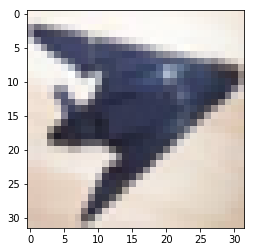

Halo szerint a legvaloszinubb osztaly:airplane - konfidenciaja:0.691997


In [25]:
y_pred(mlp,x_tst[791],cimke)